In [32]:
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
from get_coords import get_coords, domains
from mpl_toolkits.mplot3d import Axes3D

#%matplotlib notebook
%matplotlib widget

In [33]:
# phi = torch.load('../../data/our_input/torsion/phi/16pkA01_phi.pt')
# psi = torch.load('../../data/our_input/torsion/psi/16pkA01_psi.pt')
phi_dssp = torch.load('16pkA01_phi.pt')
psi_dssp = torch.load('16pkA01_psi.pt')

phi_dssp = np.radians(phi_dssp[1:])
psi_dssp = np.radians(psi_dssp[:-1])

torsion = torch.cat((phi_dssp, psi_dssp)).requires_grad_()

coords = get_coords('16pkA01')
seq = domains['16pkA01'][2]

coords

array([[5, 'GLU', 'E', ..., -15.953, 21.156, 16.122],
       [5, 'GLU', 'E', ..., -15.944, 19.956, 15.229],
       [5, 'GLU', 'E', ..., -16.724, 20.23, 13.94],
       ...,
       [192, 'LEU', 'L', ..., -6.902, 31.661, 16.767],
       [192, 'LEU', 'L', ..., -5.748, 32.421, 16.114],
       [192, 'LEU', 'L', ..., -7.745, 30.979, 15.701]], dtype=object)

In [34]:
coords_raw = torch.from_numpy(coords[coords[:, 3] != 'CB'][:, 4:].astype(np.float))

In [35]:
# %% Constants - see atomic distances.ipynb

# Angles
CNCA = torch.tensor(np.radians(122))
NCAC = torch.tensor(np.radians(111))  # ??? i am not sure about this one - From atomic_coordinates.ipynb it should be ~112
CACN = torch.tensor(np.radians(116))
CCACB = torch.tensor(np.radians(120))

# distances
CAC = 1.52
CN = 1.33
NCA = 1.45
CACB = 1.52

# minimal distance between two same atoms (C-C, N-N, CA-CA)
CC = CN * torch.cos(np.pi - CNCA) + NCA + CAC * torch.cos(np.pi - NCAC)
NN = NCA * torch.cos(np.pi - NCAC) + CAC + CN * torch.cos(np.pi - CACN)
CACA = CAC * torch.cos(np.pi - CACN) + CN + NCA * torch.cos(np.pi - CNCA)

### Distance between atoms `CA - CA` should be constant if $\omega = \pi$

In [36]:
b = torch.sqrt(CN ** 2 + NCA ** 2 - 2 * CN * NCA * torch.cos(CNCA))
CACA_omega_pi = torch.sqrt(CAC ** 2 + b ** 2 - 2 * CAC * b * torch.cos(CACN + torch.asin(torch.sin(CNCA) * NCA / b)))
CACA_omega_pi

tensor(3.7924)

In [37]:
backbone = torch.tensor([[0, NCA * torch.sin(np.pi - NCAC), 0],  # N
                   [NCA * torch.cos(np.pi - NCAC), 0, 0],          # CA
                   [NCA * torch.cos(np.pi - NCAC) + CAC, 0, 0],    # C
                  ])

**THIS IS CORRECT** - see `atomic_distances.ipynb`. There the experimental mean was 3.81

In [38]:
def vs(v):
    return torch.sqrt(torch.sum(v ** 2))

In [39]:
def cross_product(k, v):

    # definition of cross product
    cp = torch.tensor([
        k[1] * v[2] - k[2] * v[1],
        k[2] * v[0] - k[0] * v[2],
        k[0] * v[1] - k[1] * v[0]
    ])
    return cp

## Rodrigues Formula

given a vector `v` and a basis vector `k`, to calculate the coordinates of a rotated vector by angle $\theta$ around the basis vector `k` one has to use the Rodrigues formula:

$$\mathbf{v}_{rot} = \mathbf{v}cos(\theta) + (\mathbf{k} \times \mathbf{v}) sin(\theta) + \mathbf{k} (\mathbf{k} \cdot \mathbf{v})(1 - cos(\theta))$$

In [40]:
# %% Rodrigues Formula
def rodrigues(v, k, angle):
    """
    see: https://en.wikipedia.org/wiki/Rodrigues%27_rotation_formula
    """
    
    cp = cross_product(k, v)
    
    vrot = v * torch.cos(angle) + cp * torch.sin(angle) + k * (torch.sum(k * v) * (1 - torch.cos(angle)))
    return vrot

## How to find the `v` vector?

We can use the rodrigues formula here. We have a vector a unit `v0` that points to the first atom, unit vector `k` pointing to the third atom and the axis of rotation is `n` which is a unit vector $v \times k$.

The angle by which we need to rotate is $\alpha$, which if the angle from 1. to 3rd atom is $\alpha_1$ and the angle from 2nd to 4th atom is $\alpha_2$ is: $\alpha = \alpha_1 + \alpha_2 - \pi$

The final vector is (the size of the resulting vector is $||v||$):
$$||v|| * rodrigues(v_0, k, \alpha)$$

This vector than has to be shifted to the right position by simply adding to it the coordinates of the last atom in the structure.

In [41]:
def calc_v(coords, atom):

    if atom == 'N':
        v_size = CN
        angle = CACN + NCAC - np.pi
    elif atom == 'CA':
        v_size = NCA
        angle = CACN + CNCA - np.pi
    elif atom == 'C':
        v_size = CAC
        angle = CNCA + NCAC - np.pi

    k = coords[-1] - coords[-2]
    k = k / torch.sqrt(torch.sum(k ** 2))

    v0 = coords[-3] - coords[-2]
    v0 = v0 / torch.sqrt(torch.sum(v0 ** 2))

    n = cross_product(v0, k)
    n = n / vs(n)

    return v_size * rodrigues(v0, n, angle)

In [42]:
# %%
def calc_atom_coords(coord_list, atom, angle):
    k = coord_list[-1] - coord_list[-2]
    k = k / torch.sqrt(torch.sum(k ** 2))  # unit vector
    
    v = calc_v(coord_list, atom)

    rotated = rodrigues(v, k, angle)
    return rotated + coord_list[-1]

`N` atom is determined from $\psi$ angle \
`CA` atom is determined from $\omega = \pi$ angle \
`C` atom is determined from $\phi$ angle

In [43]:
def calc_dihedral(coords):
    """see https://math.stackexchange.com/questions/47059/how-do-i-calculate-a-dihedral-angle-given-cartesian-coordinates"""
    
    if len(coords) != 4:
        return 'Input should be a list of 4 atoms'
    a1, a2, a3, a4 = coords
    b1 = a2 - a1
    b2 = a3 - a2
    b3 = a4 - a3
    
    b2_n = b2 / torch.sqrt(torch.sum(b2 ** 2))
    
    n1 = cross_product(b1, b2)
    n1 = n1 / torch.sqrt(torch.sum(n1 ** 2))
    
    n2 = cross_product(b2, b3)
    n2 = n2 / torch.sqrt(torch.sum(n2 ** 2))
    
    x = torch.sum(n1 * n2)
    m = cross_product(n1, b2_n)
    y = torch.sum(m * n2)
    
    return -torch.atan2(y, x)

## Place C-beta atoms

Here we need to find two vectors: First the one we are going to rotate (`k`) and then the second is the unit vector we are going to rotate the first around (`n`). 

The vector `n` will be parallel to the vector between points where atoms `N` and `C` lie, if their distance from `CA` was the same. So the first step is to resize one of the vectors.
Then the vector `n` is simply calulated by subtracting the rescaled vector `CA-N` from `CA-C`. 

The `k` vector is a crossproduct of vectors `CA-N` and `CA-C` and will also be perpendicular to `n`. Finally we can rotate the unit vector `k` around the unit vector `n` by an angle $\alpha = 120$ (I guess)

In [44]:
def place_cbeta(residue):
    """
    Calculate coordinates of C-beta atom. Input is a list of coordinates 
    of 3 atoms in the order: N, CA, C
    
    Returns coordinates of the C-beta atom
    """
    
    v1 = residue[0] - residue[1]  # vector CA-N
    v2 = residue[2] - residue[1]  # vector CA-C

    v1_scaled = CAC * (v1 / vs(v1))

    n = v2 - v1_scaled
    n = n / vs(n)

    k = cross_product(v2, v1)
    k = k / vs(k)

    return rodrigues(k, n, CCACB) * CACB + residue[1]

In [45]:
def G(torsion, sequence):
    """
    Calculate the backbone coordinates + C-beta satisfying the input torsion angles.
    The sequence has to be inputed in order to know whether a residue is glycin or not.
    """
    
    phi, psi = torsion[:len(torsion)//2], torsion[len(torsion)//2:]
    # Initialize coordinates <=> place first 3 atoms in the space
    backbone = torch.tensor([[0, NCA * torch.sin(np.pi - NCAC), 0],  # N
                   [NCA * torch.cos(np.pi - NCAC), 0, 0],          # CA
                   [NCA * torch.cos(np.pi - NCAC) + CAC, 0, 0],    # C
                  ])
           
    for i in range(len(phi)):
        atoms = ['N', 'CA', 'C']
        angles = [psi[i], torch.tensor(np.pi), phi[i]]

        for j in range(3):
            atom = calc_atom_coords(backbone, atoms[j], angles[j])
            backbone = torch.cat((backbone, atom.view(1, 3)))
    
    # cbeta atoms
    has_cbeta = ''
    cbeta_coords = torch.empty((sum([i != 'G' for i in sequence]), 3))
    
    it = 0
    for i in range(len(sequence)):
        if sequence[i] != 'G':
            cbeta = place_cbeta(backbone[(i*3):(i*3+3)])
            cbeta_coords[it] = cbeta
            it += 1
            
    return backbone, cbeta_coords

In [46]:
def G2(torsion, sequence):
    """
    Calculate the backbone coordinates + C-beta satisfying the input torsion angles.
    The sequence has to be inputed in order to know whether a residue is glycin or not.
    """
    phi, psi = torsion[:len(torsion)//2], torsion[len(torsion)//2:]
    dist_mat_atoms = torch.empty((len(sequence), 3))
    
    # Initialize coordinates <=> place first 3 atoms in the space
    backbone = torch.tensor([[0, NCA * torch.sin(np.pi - NCAC), 0],  # N
                   [NCA * torch.cos(np.pi - NCAC), 0, 0],          # CA
                   [NCA * torch.cos(np.pi - NCAC) + CAC, 0, 0],    # C
                  ])
    
    
    i = 0
    while i < len(sequence) - 1:
        if sequence[i] == 'G':
            dist_mat_atoms[i] = backbone[3 * i + 1]
        else:
            dist_mat_atoms[i] = place_cbeta(backbone[(3 * i):(3 * (i + 1))])
        
        # backbone atoms
        atoms = ['N', 'CA', 'C']
        angles = [psi[i], torch.tensor(np.pi), phi[i]]

        for j in range(3):
            atom = calc_atom_coords(backbone, atoms[j], angles[j])
            backbone = torch.cat((backbone, atom.view(1, 3)))
        
        i += 1
    return dist_mat_atoms

In [47]:
def visualize_structure(backbone, cbeta_coords, seq):
    
    """Visualizes the entire structure: backbone + C-beta atoms
    
    In the first step generates a list of residue coordinates:
        If Glycin: only N, CA, C atoms are present.
        Else: N, CA, CB, CA, C (the CA is there twice to make the plotting easier)
    """
    with torch.no_grad():
        fig = plt.figure()

        entire_structure = torch.empty((len(backbone) + 2 * len(cbeta_coords), 3))

        it = 0
        cb_it = 0
        for i in range(len(seq)):
            N, CA, C = backbone[(3 * i):(3 * i + 3)]

            if seq[i] != 'G':
                CB = cbeta_coords[cb_it]
                cb_it += 1
                entire_structure[it:(it+5)] = torch.cat([N, CA, CB, CA, C]).view((5, 3))
                it += 5
            else:
                entire_structure[it:(it+3)] = torch.cat([N, CA, C]).view((3, 3))
                it += 3
        #return entire_structure       
        c = entire_structure.data.numpy()

        ax = fig.gca(projection='3d')
        ax.plot(c[:, 0], c[:, 1], c[:, 2])

    #ax.scatter(c[:, 0], c[:, 1], c[:, 2], s=100)

    #ax.set_xlim(np.min(c[:, 0]), np.max(c[:, 0]))
    #ax.set_ylim(np.min(c[:, 1]), np.max(c[:, 1]))
    #ax.set_zlim(np.min(c[:, 2]), np.max(c[:, 2]))

In [49]:
cl, cb = G(torsion, seq)

In [50]:
visualize_structure(cl, cb, seq)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [60]:
backbone

tensor([[0.0000, 1.3537, 0.0000],
        [0.5196, 0.0000, 0.0000],
        [2.0396, 0.0000, 0.0000]])

In [67]:
b = torch.cat((backbone, calc_atom_coords(backbone, 'N', torch.tensor(np.pi / 6)).view(1, 3)))

In [70]:
np.degrees(calc_dihedral(b))

tensor(30.0000)

In [171]:
an = []

for i in range(0, 360, 20):
    CCACB = torch.tensor(np.radians(i))
    cb0 = place_cbeta(backbone)

    #v1 = backbone[-1] - backbone[-2]
    v1 = backbone[-3] - backbone[-2]
    v2 = cb0 - backbone[-2]

    an.append(np.degrees(torch.acos(torch.sum(v1 * v2) / (vs(v1) * vs(v2)))).item())

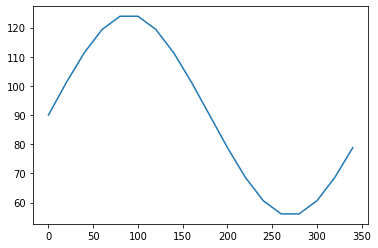

In [174]:
#%matplotlib inline
#plt.plot(np.arange(0, 360, 20), an)

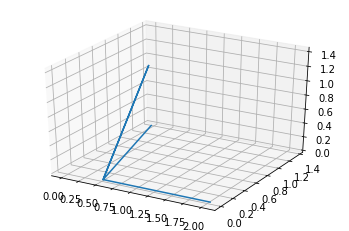

In [175]:
N, CA, C = backbone
fig = plt.figure()

c = torch.cat((N.view(1, 3), 
               CA.view(1, 3), 
               cb0.view(1, 3), 
               CA.view(1, 3),
               C.view(1, 3))).data.numpy()

ax = fig.gca(projection='3d')
ax.plot(c[:, 0], c[:, 1], c[:, 2])

In [18]:
cl, cb = G(phi_dssp[1:], psi_dssp[:-1], seq)

In [19]:
visualize_structure(cl, cb, seq)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Calculate dihedral angles

In [56]:
torsion = []
for i in range(len(coords_raw) - 3):
    torsion.append(calc_dihedral(coords_raw[i:(i+4)]).item())

torsion = torch.tensor(torsion)

psi, omg, phi = torsion[np.arange(0, len(torsion), 3)], torsion[np.arange(1, len(torsion), 3)], torsion[np.arange(2, len(torsion), 3)]

## Checking dihedral angles

In [57]:
#cl = G(phi, psi)

In [58]:
torsion = []
for i in range(len(cl) - 3):
    torsion.append(calc_dihedral(cl[i:(i+4)]).item())

torsion = np.array(torsion, dtype=np.float32)

In [59]:
psi_, omg_, phi_ = torsion[np.arange(0, len(torsion), 3)], torsion[np.arange(1, len(torsion), 3)], torsion[np.arange(2, len(torsion), 3)]

In [80]:
equals_psi = []
equals_phi = []
for i in range(len(psi_)):
    equals_psi.append(np.round(psi_, 3)[i] == np.round(psi_dssp.data.numpy()[:-1], 3)[i])
    equals_phi.append(np.round(phi_, 3)[i] == np.round(phi_dssp.data.numpy()[1:], 3)[i])

sum(equals_psi), sum(equals_phi)

(9, 0)

In [92]:
np.round(phi_dssp.data.numpy()[1:], 4)[0]# == np.round(phi_, 4)[0]

-1.4312

In [96]:
np.round(phi_, 4)[0] == phi_dssp[1].item()

False

In [28]:
def place_cbeta(residue):
    v1 = residue[0] - residue[1]  # vector CA-N
    v2 = residue[2] - residue[1]  # vector CA-C

    v1_scaled = CAC * (v1 / torch.sqrt(torch.sum(v1)))

    n = v2 - v1_scaled
    n = n / torch.sqrt(torch.sum(n ** 2))

    k = cross_product(v2, v1)
    k = k / torch.sqrt(torch.sum(k ** 2))


    v = torch.cos(CCACB) * k + \
            torch.sin(CCACB) * cross_product(n, k)

    return v * CACB + residue[1]

In [24]:
torch.sqrt(torch.sum((CACB_vec - residue[1]) ** 2))

tensor(1.5200)

In [26]:
residue = torch.cat((residue, CACB_vec.view(1, 3))).data.numpy()

fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.plot(c[:, 0], c[:, 1], c[:, 2])
ax.scatter(residue[:, 0], residue[:, 1], residue[:, 2], s=100)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## checking distances between neighboring atoms

In [23]:
d = []
for i in range(len(cl) - 1):
    d.append(torch.sqrt(torch.sum((cl[i + 1] - cl[i])**2)))

In [24]:
d[:10]

[tensor(1.4500),
 tensor(1.5200),
 tensor(1.3300),
 tensor(1.4500),
 tensor(1.5200),
 tensor(1.3300),
 tensor(1.4500),
 tensor(1.5200),
 tensor(1.3300),
 tensor(1.4500)]

In [25]:
NCA, CAC, CN

(1.45, 1.52, 1.33)

**CORRECT**

# checking angles 

In [26]:
a = []
for i in range(len(cl) - 3):
    v1, v2 = cl[i + 1] - cl[i], cl[i + 2] - cl[i + 1]            
    v1_size, v2_size = torch.sqrt(torch.sum(v1**2)), torch.sqrt(torch.sum(v2**2))
            
    angle = np.pi - torch.acos(torch.sum(v1 * v2) / (v1_size * v2_size))
            
    a.append(angle)

In [27]:
a[:10]

[tensor(1.9373),
 tensor(2.0246),
 tensor(2.1293),
 tensor(1.9373),
 tensor(2.0246),
 tensor(2.1293),
 tensor(1.9373),
 tensor(2.0246),
 tensor(2.1293),
 tensor(1.9373)]

In [28]:
NCAC, CACN, CNCA

(tensor(1.9373), tensor(2.0246), tensor(2.1293))

**CORRECT**

# checking distance between two CA atoms

In [29]:
dca = []
for i in range(len(cl) // 3 - 1):
    CA1, CA2 = cl[3 * i + 1], cl[3 * (i + 1) + 1]
    dca.append(torch.sqrt(torch.sum((CA1 - CA2)**2)))

In [30]:
dca[:10]

[tensor(3.7924),
 tensor(3.7924),
 tensor(3.7924),
 tensor(3.7924),
 tensor(3.7924),
 tensor(3.7924),
 tensor(3.7924),
 tensor(3.7924),
 tensor(3.7924),
 tensor(3.7924)]

**CORRECT**

In [32]:
psi_dssp[:-1]

tensor([-0.7505,  2.5133,  2.4609,  2.9671, -0.5934, -0.3142,  0.0698,  2.6180,
         2.0595, -0.2618,  2.1293,  0.0000,  2.5307,  1.9199,  2.0944,  2.0769,
         2.0944,  1.8326,  2.8798,  1.7104,  0.4363,  1.2217,  2.6704,  2.3387,
         2.4784,  2.1293,  0.6632,  0.0175,  2.4260,  2.2340, -0.0698,  1.8850,
         0.2443, -0.8203, -0.5934, -0.7679, -0.7156, -0.4189, -0.3142, -0.8552,
        -0.6981, -0.7854, -0.7330, -0.6807, -0.8029, -0.8727, -0.7505, -0.6283,
        -0.0349,  0.3840, -3.0543,  2.7751,  2.3038,  1.7977,  2.3736,  2.3736,
         2.9845,  2.8100,  2.2340, -2.6878,  1.2217,  2.7227, -0.9076,  2.7402,
         2.5831,  2.4609, -0.6109, -0.5934, -0.1920, -0.7854, -0.9425, -0.9599,
        -0.8378, -0.5760, -0.6807, -0.1571, -0.0175,  2.9496,  2.0769,  2.0944,
         0.1396,  2.4609,  1.9897, -0.7505, -0.4363,  0.3491,  2.5482,  0.0349,
        -0.7679, -0.4363, -0.6632, -0.8029, -0.8029, -0.6981, -0.7330, -0.7505,
        -0.7156, -0.6632, -0.3491,  0.71

In [36]:
cl = G(phi_dssp[1:], psi_dssp[:-1])
fig = plt.figure()

c = cl.data.numpy()

ax = fig.gca(projection='3d')
ax.plot(c[:, 0], c[:, 1], c[:, 2])
#ax.scatter(c[:, 0], c[:, 1], c[:, 2], s=100)

ax.set_xlim(torch.min(cl[:, 0]), torch.max(cl[:, 0]))
ax.set_ylim(torch.min(cl[:, 1]), torch.max(cl[:, 1]))
ax.set_zlim(torch.min(cl[:, 2]), torch.max(cl[:, 2]))

del fig

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [404]:
cl = G(-phi, -psi)
fig = plt.figure()

c = cl.data.numpy()

ax = fig.gca(projection='3d')
ax.plot(c[:, 0], c[:, 1], c[:, 2])
#ax.scatter(c[:, 0], c[:, 1], c[:, 2], s=100)

ax.set_xlim(torch.min(cl[:, 0]), torch.max(cl[:, 0]))
ax.set_ylim(torch.min(cl[:, 1]), torch.max(cl[:, 1]))
ax.set_zlim(torch.min(cl[:, 2]), torch.max(cl[:, 2]))

del fig

/home/tomas/miniconda3/envs/pyml/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# TRUTH

In [20]:
coords_backbone = coords[coords[:, 3] != 'CB']

In [21]:
coords_backbone[:9, 3]

array(['N', 'CA', 'C', 'N', 'CA', 'C', 'N', 'CA', 'C'], dtype=object)

In [22]:
residues = 3*3#len(coords_backbone)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(coords_backbone[:residues, 4].astype(np.float), coords_backbone[:residues, 5].astype(np.float), coords_backbone[:residues, 6].astype(np.float))

c = cl.data.numpy()
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(c[:residues, 0], c[:residues, 1], c[:residues, 2])
#ax.scatter(coords_backbone[:residues, 4].astype(np.float), coords_backbone[:residues, 5].astype(np.float), coords_backbone[:residues, 6].astype(np.float), s=100)

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [108]:
phi_dssp

tensor([ 0.0000, -1.4312, -1.1345, -2.0246, -0.9425, -1.0821, -1.7453, -1.6755,
        -1.5184, -2.0944, -1.0996,  1.3963, -1.5882, -1.6581, -1.7279, -1.5010,
        -2.1118, -1.5010, -1.8151, -1.8675, -2.0071, -1.3265, -1.5533, -1.3265,
        -2.2340, -2.3562,  0.9250,  1.4312, -1.9722, -1.2566, -1.7104, -2.8100,
        -1.6406, -0.8378, -1.0821, -1.2043, -1.0472, -1.1345, -1.3788, -0.8727,
        -0.9599, -1.0996, -1.1170, -1.0297, -1.0472, -1.0472, -1.0297, -1.0647,
        -1.4137,  1.6057, -1.7802, -2.1817, -2.0769, -2.0246, -1.5708, -2.1817,
        -2.8623, -2.1468, -2.4609,  1.0647, -2.2864, -1.1694, -1.0123,  1.6057,
        -2.4086, -1.1868, -0.8901, -0.9948, -1.3614, -0.9774, -0.8901, -0.9076,
        -0.8901, -1.0821, -1.0996, -1.2566,  1.5533, -1.4137, -1.8151, -0.9076,
         1.3265, -1.0297, -2.6180, -0.8203, -1.0821, -1.9548, -1.3439, -1.6232,
        -0.8901, -1.2043, -1.1868, -0.9948, -1.0821, -1.0821, -1.0647, -1.0297,
        -1.0647, -1.2915, -1.3788,  1.08

In [351]:
cl_real = torch.tensor([[0, NCA * torch.sin(np.pi - NCAC), 0],        # N
                   [NCA * torch.cos(np.pi - NCAC), 0, 0],        # CA
                   [NCA * torch.cos(np.pi - NCAC) + CAC, 0, 0],  # C
                  ])

for i in range(len(phi)-1):
    atoms = ['N', 'CA', 'C']
    angles = [np.pi - psi[i], torch.tensor(0.0), np.pi - phi[i]]
    
    for j in range(3):
        atom = calc_atom_coords(cl_real, atoms[j], angles[j])
        cl_real = torch.cat((cl_real, atom.view(1, 3)))

In [352]:
cl_real

tensor([[ 0.0000,  1.3444,  0.0000],
        [ 0.5432,  0.0000,  0.0000],
        [ 2.0632,  0.0000,  0.0000],
        ...,
        [10.0138, 31.8850,  4.0874],
        [ 9.7240, 33.0190,  3.2315],
        [10.9879, 33.7453,  2.8011]])

In [354]:
fig = plt.figure()

c = cl_real.data.numpy()

ax = fig.gca(projection='3d')
ax.plot(c[:, 0], c[:, 1], c[:, 2])

/home/tomas/miniconda3/envs/pyml/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [125]:
N_1 = calc_atom_coords(cl, 'N', psi[0])
N_1

tensor([ 4.5538, -0.1021,  1.2099])

In [126]:
torch.sqrt(torch.sum((N_1 - cl[-1])**2))

tensor(1.3300)

### 1. Calculate coordinates of a new Atom ("N" in this case) in the plane of previous 3 atoms

In [9]:
N1 = torch.tensor([NCA * torch.cos(np.pi - NCAC) + CAC + CN * torch.cos(np.pi - CACN), 
                   CN * torch.sin(np.pi - CACN), 
                   0])
N1

tensor([2.7387, 1.1954, 0.0000])

<IPython.core.display.Javascript object>


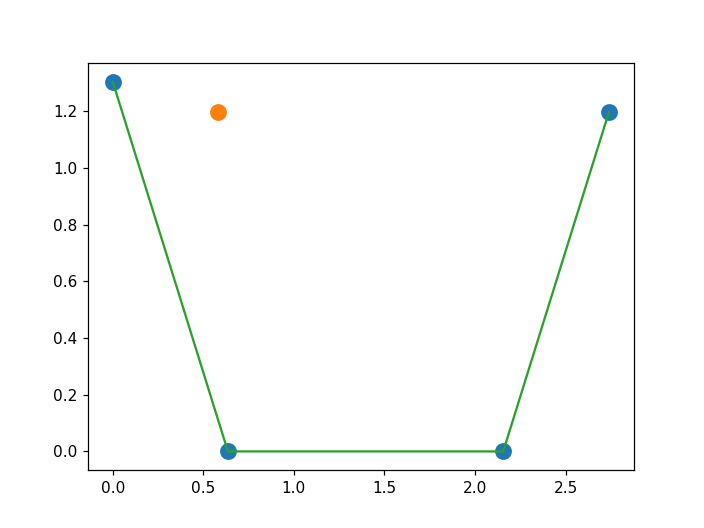

In [20]:
c = torch.cat((cl, N1.view(1, 3)))
fig = plt.figure()
plt.plot(c[:, 0], c[:, 1], '.', markersize = 20)
plt.plot(v[0], v[1], '.', markersize = 20)
plt.plot(c[:, 0], c[:, 1])

### Rotate the atom along the axis with a basis vector "k"

In [11]:
v = N1 - cl[-1]
k = cl[-1] - cl[-2]
k = k / torch.sqrt(torch.sum(k**2))

In [12]:
N_new = rodrigues(v, k, torch.tensor(0.5)) + cl[-1]
N_new

tensor([2.7387, 1.0491, 0.5731])

In [13]:
torch.sqrt(torch.sum((N_new - cl[-1])**2))

tensor(1.3300)

In [14]:
a = torch.empty((36, 3))
for i, angle in enumerate(np.linspace(-np.pi, np.pi, 36)):
    a[i] = rodrigues(v, k, torch.tensor(angle)) + cl[-1]

c = torch.cat((cl, a))

In [15]:
rodrigues(v, k, torch.tensor(np.pi))

tensor([ 5.8303e-01, -1.1954e+00, -1.0450e-07])

In [16]:
#a = rodrigues(v, k, torch.tensor(np.pi)) + cl[-1]
#c = torch.cat((cl, a.view(1, 3)))

<IPython.core.display.Javascript object>


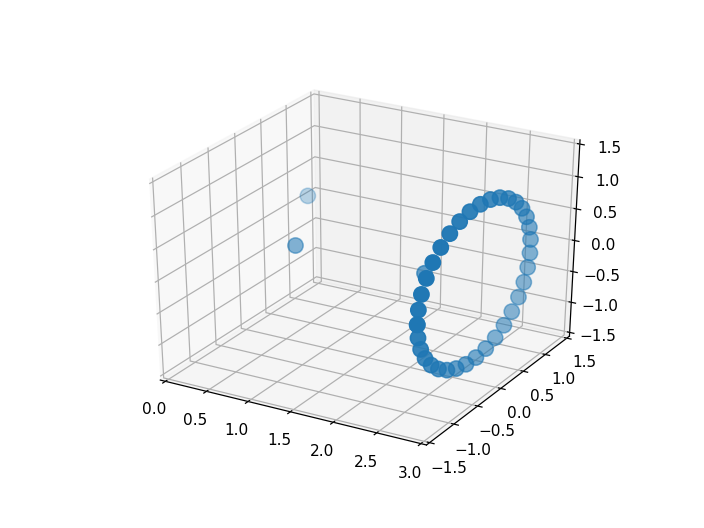

(-1.5, 1.5)

In [19]:
fig = plt.figure()
ax = fig.gca(projection='3d')
#ax.plot(c[:, 0], c[:, 1], c[:, 2])
ax.scatter(c[:, 0], c[:, 1], c[:, 2], s=100)
ax.set_xlim(0, 3)
ax.set_ylim(-1.5, 1.5)
ax.set_zlim(-1.5, 1.5)

---

In [23]:
cl

tensor([[0.0000, 1.3033, 0.0000],
        [0.6356, 0.0000, 0.0000],
        [2.1556, 0.0000, 0.0000]])

In [34]:
n = cross_product(cl[-3] - cl[-2], cl[-1] - cl[-2])
n = n / torch.sqrt(torch.sum(n ** 2))
n

tensor([ 0.,  0., -1.])

In [35]:
v0 = cl[-1] - cl[-2]
v0

tensor([1.5200, 0.0000, 0.0000])

In [41]:
v = torch.cos(np.pi - CACN) * k + torch.sin(np.pi - CACN) * cross_product(-n, k)
#v = v / torch.sqrt(torch.sum(v ** 2))
v * CN + cl[-1]

tensor([2.7387, 1.1954, 0.0000])

In [43]:
def calc_v(coords, atom):
    
    if atom == 'N':
        v_size = CN
        angle = CACN
    elif atom == 'CA':
        v_size = NCA
        angle = CNCA
    elif atom == 'C':
        v_size = CAC
        angle = NCAC
    
    k = coords[-1] - coords[-2]
    k = k / torch.sqrt(torch.sum(k**2))
    
    n = cross_product(coords[-3] - coords[-2], coords[-1] - coords[-2])
    n = n / torch.sqrt(torch.sum(n ** 2))
    
    v = torch.cos(np.pi - angle) * k + torch.sin(np.pi - angle) * cross_product(-n, k)
    return v * CN + cl[-1]

---

In [341]:
c = cl
c = torch.cat((c, N1.view(1, 3)))
c = c.data.numpy()

<IPython.core.display.Javascript object>


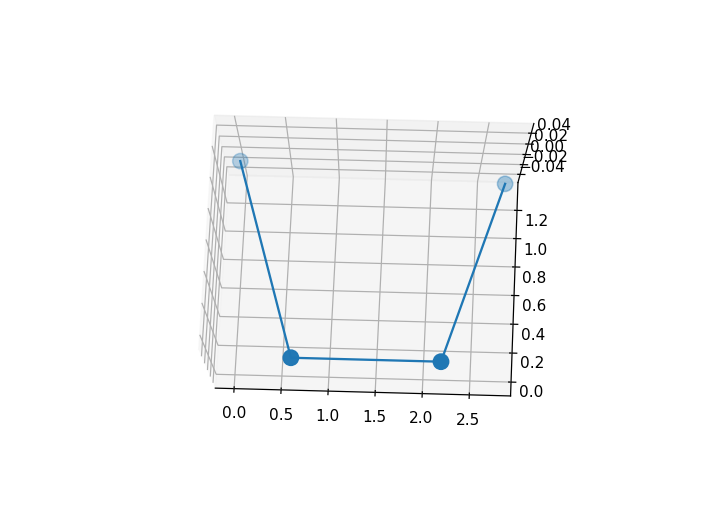

In [342]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot(c[:, 0], c[:, 1], c[:, 2])
ax.scatter(c[:, 0], c[:, 1], c[:, 2], s=100)

In [167]:
torch.cat((co, N_new.view(1, 3)))

tensor([[0.0000, 0.0000, 0.0000],
        [1.4500, 0.0000, 0.0000],
        [2.3000, 1.2601, 0.0000],
        [1.6294, 2.4157, 0.0000]])

In [168]:
np.sqrt(np.sum((c[-1] - c[-2])**2))

1.336033

In [169]:
CN

1.33

In [92]:
int(np.random.rand(1) * 100) % 3

1